# Prerequisite
* Load required packages and load images (already uploaded on  Blackboard) in Colab
* Create your own copy of notebook and add required code snippets in between the questions subsections. Also display the figures at each stage.

*Colab can be exported as a notebook file or Python file by **File > Download .ipynb** or **File > Download .py**. Exported notebook files can be reloaded into Google Colab or used in Jupyter Notebook.
* Please go through [Colab document](https://colab.research.google.com/drive/1YKHHLSlG-B9Ez2-zf-YFxXTVgfC_Aqtt) for further information.

* **Use ONLY following numpy and tensorflow/pytorch functions for any operations**

In [115]:
import tensorflow as tf
import numpy as np
from scipy import ndimage as nd
from scipy import interpolate as inter
from matplotlib import pyplot as plt
import imageio.v2 as imageio
import scipy.linalg as scla ## For Eigenvalue and Eigenvectors
import cv2 as cv

In [116]:
def RMSD(img1,img2):
  out1 = np.sqrt(np.power(img1-img2, 2).sum()/np.prod(img1.shape))
  return out1



#Q1) PCA for Image Denoising of RedFort2_noisy.png
 Assume the pixel dimensions to be equal along both axes, i.e., assume an aspect ratio of 1:1 for the axes.

In [117]:
img_path =  'RedFort2_gray.jpg'
img1_a = imageio.imread(img_path)

#####################  Not Part of Solution ############################
print('Data_type is', img1_a.dtype)
print('Image Size is {}'.format(img1_a.shape))
print('Image min and max are ({}, {})'.format(img1_a.min(),img1_a.max()))
#########################################################################


Data_type is uint8
Image Size is (600, 1200, 3)
Image min and max are (0, 255)


##(a) [**0 Marks**] Show the Original Image

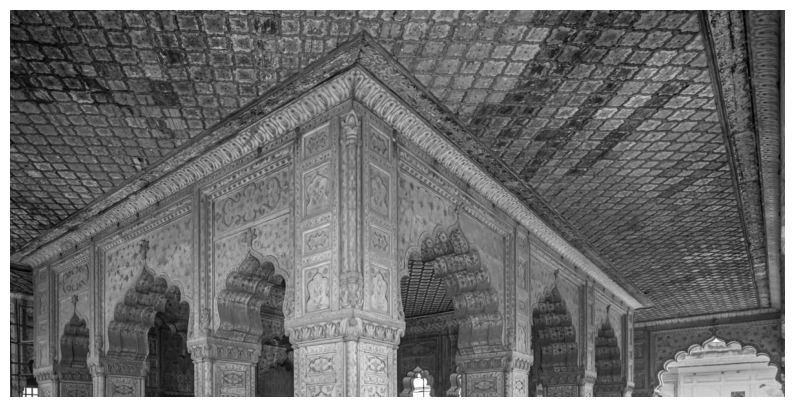

In [94]:
plt.figure(figsize=(10,10))
plt.imshow(img1_a, cmap='gray')
plt.axis('off')
plt.show()

##(b)[**0 Points**] Show the Corrupted image

In [95]:
img_path =  'RedFort2_noisy.png'
img1_b = imageio.imread(img_path)
#####################  Not Part of Solution ############################
print('Data_type is', img1_b.dtype)
print('Image Size is {}'.format(img1_b.shape))
print('Image min and max are ({}, {})'.format(img1_b.min(),img1_b.max()))
#########################################################################

Data_type is uint8
Image Size is (600, 1200)
Image min and max are (0, 255)


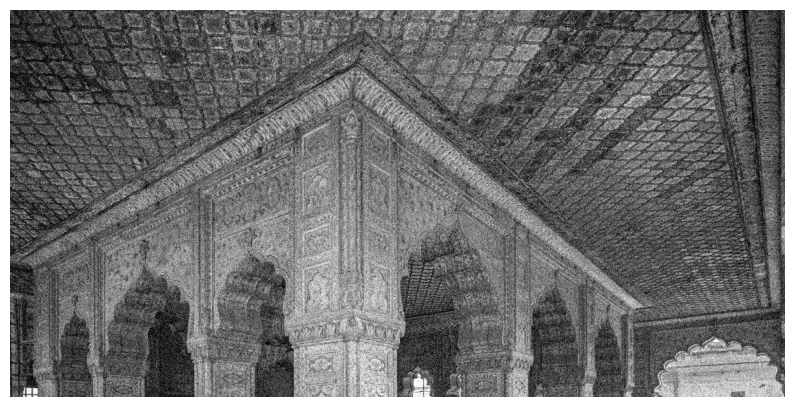

In [96]:
plt.figure(figsize=(10,10))
plt.imshow(img1_b, cmap='gray')
plt.axis('off')
plt.show()

<p> Consider Patch $P_{ij}$ of size $p \times p$ around pixel location $(i,j)$ in <b>Corrupted image</b>.
Randomly collect $K=290$ $(p \times p)$ patches from within a $31\times 31$ neighborhood centered at $(i,j)$.</p>
[Note: make sure $P_{ij}$ should be part of $290$ patches]
<p>
Let ${\bar P_{ij}}$ be $(p^2×1)$ column vector of patch $P_{ij}$.
</p>
<p>
Let $X_{ij}$ be matrix of size $(p^2×290)$, where each column represents $p\times p$ patch from $290$ patches.
Let $C_{ij} = X_{ij}X_{ij}^T$ is $(p^2×p^2)$ matrix.
</p>
<p>$w_{ij},v_{ij} = numpy.linalg.eig(C_{ij})$</p>
<p>
Where $w_{ij}$ is $(p^2×1)$ matrix with eigenvalues of $C_{ij}$ and $v_{ij}$ is $(p^2×p^2)$ matrix with corresponding eigenvectors of $C_{ij}$ in columns. Make sure all eigenvectors are unit norm.
</p>
<p>
Let $\alpha_{ij}^k = v_{ij}^TX_{ij}[:,k]$, for $k = \{1,2,...,K\}$, be matrix of size $(p^2×1)$.
</p>
<p>
Let ${\bar \alpha}_{ij}^2[l] = max(0,\frac{1}{K}\sum_{k=1}^K((\alpha_{ij}^k[l])^2-\sigma^2))$, where $l=\{1,2,...,p^2\}$
</p>
<p>
Let $\alpha_{ij} = v_{ij}^T{\bar P_{ij}}$, be matrix of size $(p^2×1)$.
</p>
<p>
Now, $\beta_{ij}[l] = \frac{1}{1+\frac{\sigma^2}{{\bar \alpha}_{ij}^2[l]}}\alpha_{ij}[l]$, where $l=\{1,2,...,p^2\}$ and $\beta_{ij}$ is a matrix of size $(p^2×1)$.
</p>
<p>
Let ${\bar Q_{ij}}= v_{ij}\beta_{ij}$ be matrix of size $(p^2×1)$. Now let $Q_{ij}$ be $(p×p)$ denoised patch from ${\bar Q_{ij}}$.
</p>
<p>
Now replace patch $P_{ij}$ with patch $Q_{ij}$ to denoise image.  
Complete the Following Function

In [109]:
def PCAID(img, patch_size, window_size, noise_std, stride):
    
    #Using arguments
    h, w = img.shape
    p = patch_size
    num_samples = 290
    noise_var = noise_std ** 2

    #Initializing
    denoised_img = np.zeros((h, w), dtype=np.float64)
    patch_count = np.zeros((h, w), dtype=np.float64)
    max_eigenvalues = np.zeros((h, w), dtype=np.float64)

    #Boundary Handling (Padding)
    pad = window_size // 2
    img_padded = np.pad(img, ((pad, pad), (pad, pad)), mode='reflect')

    
    for x in range(0, h, stride):
        for y in range(0, w, stride):
            
            x1, x2 = x + pad - pad, x + pad + pad + 1
            y1, y2 = y + pad - pad, y + pad + pad + 1
            local_region = img_padded[x1:x2, y1:y2]

            
            patches = []
            for _ in range(num_samples):
                r, c = np.random.randint(0, window_size - p + 1, size=2)
                patches.append(local_region[r:r+p, c:c+p].flatten())

            
            X = np.array(patches).T

            
            cov_matrix = X @ X.T

            
            eig_vals, eig_vecs = np.linalg.eigh(cov_matrix)
            sorted_indices = np.argsort(eig_vals)[::-1]
            eig_vals, eig_vecs = eig_vals[sorted_indices], eig_vecs[:, sorted_indices]

            
            max_eigenvalues[x, y] = eig_vals[0]

            
            projections = eig_vecs.T @ X

            
            signal_var = np.maximum(0, (1 / num_samples) * np.sum(projections ** 2, axis=1) - noise_var)

            
            filter_coeff = signal_var / (signal_var + noise_var)

            
            ref_x, ref_y = x + pad - p // 2, y + pad - p // 2
            ref_patch = img_padded[ref_x:ref_x+p, ref_y:ref_y+p].flatten()

            
            proj_ref = eig_vecs.T @ ref_patch

           
            denoised_patch = eig_vecs @ (filter_coeff * proj_ref)
            denoised_patch = denoised_patch.reshape(p, p)

           
            x_start, x_end = max(0, x - p // 2), min(h, x + p // 2 + 1)
            y_start, y_end = max(0, y - p // 2), min(w, y + p // 2 + 1)

            
            px_start, py_start = max(0, p // 2 - x), max(0, p // 2 - y)
            px_end, py_end = px_start + (x_end - x_start), py_start + (y_end - y_start)

            
            denoised_img[x_start:x_end, y_start:y_end] += denoised_patch[px_start:px_end, py_start:py_end]
            patch_count[x_start:x_end, y_start:y_end] += 1

    #Normalizing
    denoised_img = np.divide(denoised_img, patch_count, where=patch_count > 0, out=np.zeros_like(denoised_img))
    denoised_img = np.clip(denoised_img, 0, 255).astype(np.uint8)

    return denoised_img, max_eigenvalues


## Now use $PCAID$ function to find following outputs.

##(c)[**4 Points**] Plot image of $max(w_{ij})$, which will be same size as original image

[[6240.83310141    0.            0.         ...    0.
     0.            0.        ]
 [   0.            0.            0.         ...    0.
     0.            0.        ]
 [   0.            0.            0.         ...    0.
     0.            0.        ]
 ...
 [   0.            0.            0.         ...    0.
     0.            0.        ]
 [   0.            0.            0.         ...    0.
     0.            0.        ]
 [   0.            0.            0.         ...    0.
     0.            0.        ]]


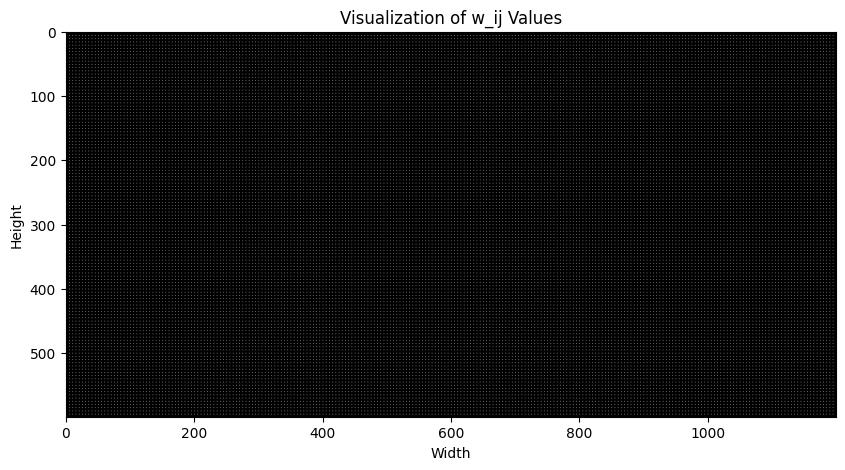

In [112]:
psize = 7
wsize = 35
sig = 25 
step = 5  

# Call PCAID function
new_image, w_ij = PCAID(img1_b, psize, wsize, sig, step)

# Print w_ij
print(w_ij)

# Plot w_ij
plt.figure(figsize=(10, 5))
plt.imshow(w_ij,cmap='gray')
plt.title('Visualization of w_ij Values')
plt.xlabel('Width')
plt.ylabel('Height')
plt.show()

##(d)[**4 Points**]Show the Denoised Image

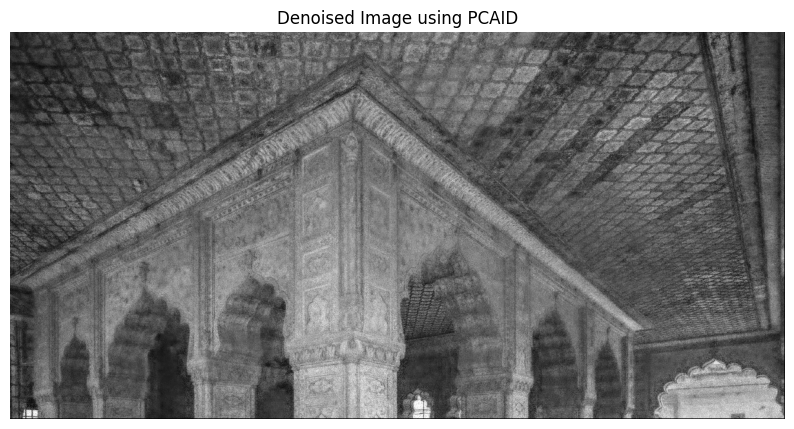

In [113]:
plt.figure(figsize=(10, 10))
plt.imshow(new_image, cmap='gray')  # Display in grayscale
plt.axis("off")
plt.title("Denoised Image using PCAID")
plt.show()

##(e)[**2 Points**] Print RMSE value between original image and Denoised image

In [118]:

img1_a = cv.cvtColor(img1_a, cv.COLOR_BGR2GRAY)


rmse = RMSD(img1_a, new_image)

print("RMSE = ",rmse)

RMSE =  8.835618572321666
